In [40]:
import numpy as np
from pyannote.audio import Pipeline, Model, Inference
import os
from dotenv import load_dotenv
import random
import torch
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift
from sklearn.metrics import rand_score, adjusted_mutual_info_score, silhouette_score, davies_bouldin_score
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd

In [41]:
load_dotenv()
token = os.getenv("HUGGING_FACE_TOKEN")
folder = "speakers"
directories = ["SPEAKER_00","SPEAKER_01","SPEAKER_02"]
speaker_dictionaries  = [f"{folder}/{dir}" for dir in directories]

In [42]:
def insert_files_in_list(list_files: list, labels: list, label: str,directory: str):
  for f in os.listdir(directory):
    if os.path.isfile(os.path.join(directory, f)):
      list_files.append(os.path.join(directory, f))
      labels.append(label)
def clusterisation_result(list_files_name: list,labels: list,prediction: list):
  d = {}
  p = {}
  prediction_n = [ int(f) for f in prediction]
  for l in sorted(list(zip(labels,prediction_n))):
    if l[0] in d:
      if l[1] in d[l[0]]:
        d[l[0]][l[1]]+=1
      else:
        d[l[0]][l[1]] = 1
    else:
      d[l[0]] = {}
      d[l[0]][l[1]] = 1
  for l in sorted(list(zip(list_files_name,prediction_n))):
    if l[1] in p:
      if not l[0] in p[l[1]]:
        p[l[1]].append(l[0])
    else:
      p[l[1]] = []
      p[l[1]].append(l[0])
  for key, value in sorted(p.items()):
      print(f"{key}: {[ v.split('/')[1] for v in value]}")


  for key, value in d.items():
      print(f"{key}: {value}")

  print("Rand Index:",rand_score(labels,prediction_n))
  print("Adjusted Rand Index:",adjusted_mutual_info_score(labels,prediction_n))
  print("-"*100)
  #return d, p

def function_heatmap(embedding: list):
  """speaker_1_list = []
  for dir in list_dictionary:
    insert_files_in_list(speaker_1_list,[],'a',dir)"""
  n = len(embedding)
  matrix = [[0]*n for _ in range(n)]
  for i in range(n):
    for j in range(n):
      matrix[i][j] = cdist([embedding[i]],[embedding[j]],metric="cosine")[0,0]
  sns.heatmap(matrix)
  return matrix
def distribution(speaker_dictionaries,matrix):
  previous_count = 0
  cordinates_for_speaker = []
  for speaker in speaker_dictionaries:
    cordinates_for_speaker.append((previous_count,previous_count+len(os.listdir(speaker))))
    previous_count+=len(os.listdir(speaker))
  print(cordinates_for_speaker)
  from_same_group = []
  for speaker in cordinates_for_speaker:
    l_cord = speaker[0]
    r_cord = speaker[1]
    for row in matrix[l_cord:r_cord]:
      for e in row[l_cord:r_cord]:
        from_same_group.append(e)

  np_matrix = np.array(deepcopy(matrix))
  for speaker in cordinates_for_speaker:
    l_cord = speaker[0]
    r_cord = speaker[1]
    np_matrix[l_cord:r_cord,l_cord:r_cord] = 2
  different_group = np_matrix.flatten()[np_matrix.flatten()!=2]

  plt.hist(from_same_group,bins=20,color='green',alpha=0.5)
  plt.hist(different_group,bins=10,color='red',alpha=0.5)
  plt.show()

def k_means_fixed(list_files_new,labels_new,embedding, no_cluster):
  kmeans = KMeans(n_clusters=no_cluster)
  kmeans.fit(embedding)
  prediction_k_means_fixed = kmeans.labels_

  clusterisation_result(list_files_new,labels_new,prediction_k_means_fixed)
def agglomerative(list_files_new,labels_new,embedding, no_cluster):
  print("Agglomerative method")
  model = AgglomerativeClustering(n_clusters=no_cluster,linkage='average')
  prediction = model.fit_predict(embedding)

  clusterisation_result(list_files_new,labels_new,prediction)
def mean_shift(list_files_new,labels_new,embedding):
  print("Mean Shift method")
  meanshift = MeanShift()
  prediction = meanshift.fit_predict(embedding)

  clusterisation_result(list_files_new,labels_new,prediction)
def wss(embedding):
  WSS = []
  for i in range(1,20):
    kmeans = KMeans(n_clusters=i,random_state=0)
    kmeans.fit(embedding)
    WSS.append(kmeans.inertia_)
  plt.plot(range(1,20),WSS)

minimal_treshold = 0.4
def calculate_threshold(i,embedding):
  cosine_dist = sorted([ cdist([i],[j],metric='cosine')[0,0] for j in embedding])
  difference = []
  max_v = 0
  index = 0
  for i in range(1,len(cosine_dist)-1):
    diff = cosine_dist[i+1]-cosine_dist[i]
    difference.append(diff)
    if diff>max_v and (cosine_dist[i]+cosine_dist[i+1])/2>minimal_treshold:
      index = i
      max_v = diff
  treshold = (cosine_dist[index+1]+cosine_dist[index])/2
  if treshold<0.8:
    return treshold
  return 0.8


def my_algorithm_v2(list_files_new,labels_new,embedding):
  print("My algorithm")
  n = len(list_files_new)
  prediction = [-1]*n
  cluster=0
  for i,audio_first in enumerate(embedding):
    if prediction[i]>-1:
      continue
    treshold = calculate_threshold(audio_first,embedding)
    for j,audio_second in enumerate(embedding):
      if prediction[j]>-1:
        continue
      if cdist([audio_first],[audio_second],metric='cosine')[0,0]<treshold:
        prediction[j] = cluster
    cluster+=1

  clusterisation_result(list_files_new, labels_new, prediction)

In [44]:
model = Model.from_pretrained("pyannote/embedding",
                              use_auth_token=token)
inference = Inference(model, window="whole")
no_cluster = len(speaker_dictionaries)
list_files = []
labels = []

for directory in speaker_dictionaries:
  insert_files_in_list(list_files,labels,directory,directory)
print(list_files)
embedding = []
embedding = [inference(file) for file in list_files]
combined = list(zip(list_files,labels,embedding))
print(combined)
list_files_new, labels_new, embedding_new = zip(*combined)

Lightning automatically upgraded your loaded checkpoint from v1.2.7 to v2.5.1.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../.cache/torch/pyannote/models--pyannote--embedding/snapshots/4db4899737a38b2d618bbd74350915aa10293cb2/pytorch_model.bin`
Lightning automatically upgraded your loaded checkpoint from v1.2.7 to v2.5.1.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../.cache/torch/pyannote/models--pyannote--embedding/snapshots/4db4899737a38b2d618bbd74350915aa10293cb2/pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.3.2. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.8.1+cu102, yours is 2.7.0+cu118. Bad things might happen unless you revert torch to 1.x.
Model was trained with pyannote.audio 0.0.1, yours is 3.3.2. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.8.1+cu102, yours is 2.7.0+cu118. Bad things might happen unless you revert torch to 1.x.
['speakers/SPEAKER_00/0.0_1.7.mp3', 'speakers/SPEAKER_00/9.0_11.6.mp3', 'speakers/SPEAKER_00/3.4_6.7.mp3', 'speakers/SPEAKER_01/11.6_12.8.mp3', 'speakers/SPEAKER_02/1.9_3.0.mp3', 'speakers/SPEAKER_02/5.6_8.4.mp3', 'speakers/SPEAKER_02/13.8_15.0.mp3']
[('speakers/SPEAKER_00/0.0_1.7.mp3', 'speakers/SPEAKER_00', array([ 2.26784000e+01, -2.32135372e+01,  1.98729191e+01, -5.03256569e+01,
       -6.16819038e+01, -9.30863094e+00, -2.48020725e+01,  6.77397461e+01,
        4.80992746e+00, -2.64268208e+00,  6.706

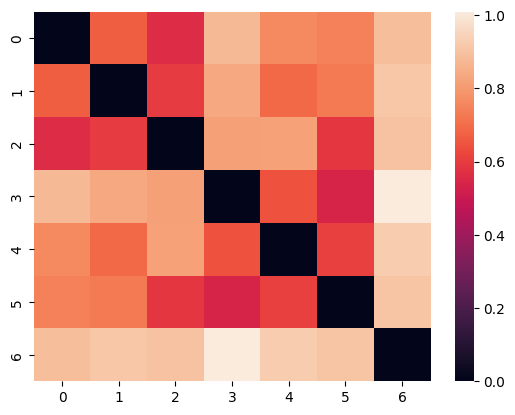

In [45]:
matrix = function_heatmap(embedding)

In [46]:
print(silhouette_score(embedding_new, labels_new))
print(davies_bouldin_score(embedding_new,labels_new))

0.033832256
1.4287611358895707


In [47]:
wss(embedding_new)

ValueError: n_samples=7 should be >= n_clusters=8.

In [48]:
agglomerative(list_files_new,labels_new,embedding_new,3)
print("K Means fixed method")
k_means_fixed(list_files_new,labels_new,embedding_new,3)
print("K Means fixed method with Elbow Technique")
k_means_fixed(list_files_new,labels_new,embedding_new,2)
mean_shift(list_files_new,labels_new,embedding_new)
#my_algorithm(list_files_new,labels_new,embedding_new,0.5)
my_algorithm_v2(list_files_new,labels_new,embedding_new)

Agglomerative method
0: ['SPEAKER_00', 'SPEAKER_00', 'SPEAKER_00', 'SPEAKER_02', 'SPEAKER_02']
1: ['SPEAKER_02']
2: ['SPEAKER_01']
speakers/SPEAKER_00: {0: 3}
speakers/SPEAKER_01: {2: 1}
speakers/SPEAKER_02: {0: 2, 1: 1}
Rand Index: 0.6190476190476191
Adjusted Rand Index: 0.31529988875197146
----------------------------------------------------------------------------------------------------
K Means fixed method
0: ['SPEAKER_00', 'SPEAKER_00', 'SPEAKER_00', 'SPEAKER_01', 'SPEAKER_02']
1: ['SPEAKER_02']
2: ['SPEAKER_02']
speakers/SPEAKER_00: {0: 3}
speakers/SPEAKER_01: {0: 1}
speakers/SPEAKER_02: {0: 1, 1: 1, 2: 1}
Rand Index: 0.5238095238095238
Adjusted Rand Index: -0.04461204850611699
----------------------------------------------------------------------------------------------------
K Means fixed method with Elbow Technique
0: ['SPEAKER_01', 'SPEAKER_02', 'SPEAKER_02']
1: ['SPEAKER_00', 'SPEAKER_00', 'SPEAKER_00', 'SPEAKER_02']
speakers/SPEAKER_00: {1: 3}
speakers/SPEAKER_01: {0: 1}
s